In [1]:
import math

from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import HTML

from matk.utils.animation import animate_frames
from matk.models import FlockingModel

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
BIG_STEPS = 1_000

## Base model

In [ ]:
flock_model = FlockingModel(
    n_points=200,
    field_size=(128,128), 
    step_size=5,
    cohere_speed=0.075,
    align_speed=0.125,
    separate_speed=0.0375,
    vision=10,
    minimum_separation=2,
    n_eagles=3,
    eagles_speed=0.125,
    eagles_step_size=7.5,
    eagles_attack_radius=3,
)

In [ ]:
flock_model.run_n_steps(BIG_STEPS)

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Start')
plt.imshow(flock_model[0])
plt.show()

plt.figure(figsize=(10,10))
plt.title('End')
plt.imshow(flock_model[-1])
plt.show()

# Var 2

In [3]:
def make_exp_eagles_kill(model_config, use_parallel = True):
    # 10 10 10 
    egale_speed_space = np.linspace(0.125, 0.25, num=8)
    n_eagles_space = list(range(1, 8))
    eagles_step_size_space = list(range(1, 8))
    n_monte_carlo = 8
    
    if use_parallel:
        def make_one_exp(e_sp_t, e_n_t, e_ss_t):
            temp_results = []
            for _ in range(n_monte_carlo):
                model_config['eagles_speed'] = e_sp_t
                model_config['eagles_step_size'] = e_ss_t
                model_config['n_eagles'] = e_n_t

                temp_model = FlockingModel(**model_config)
                temp_model.run_n_steps(BIG_STEPS, verbose=False)

                survived_for = len(temp_model.points)
                temp_results.append(survived_for)

            return temp_results, e_sp_t, e_n_t, e_ss_t
        
        temp_r = Parallel(n_jobs=12)(delayed(make_one_exp)(e_sp, e_n, e_ss ) for e_sp, e_n, e_ss in product(
            egale_speed_space,
            n_eagles_space,
            eagles_step_size_space,
        ))
        
        return (
            np.stack([el[0] for el in temp_r]),
            np.array([el[1] for el in temp_r]),
            np.array([el[2] for el in temp_r]),
            np.array([el[3] for el in temp_r])
        )

    else:
        
        survival_len_space = []
        new_egale_speed_space = []
        new_n_eagles_space = []
        new_eagles_step_size_space = []

        for e_sp, e_n, e_ss in tqdm(product(
            egale_speed_space,
            n_eagles_space,
            eagles_step_size_space,
        ), total=20*9*9):
            temp_results = []
            for _ in range(n_monte_carlo):
                model_config['eagles_speed'] = e_sp
                model_config['eagles_step_size'] = e_ss
                model_config['n_eagles'] = e_n

                temp_model = FlockingModel(**model_config)
                temp_model.run_n_steps(BIG_STEPS, verbose=False)

                survived_for = len(temp_model.points)
                temp_results.append(survived_for)

            survival_len_space.append(temp_results)
            new_egale_speed_space.append(e_sp)
            new_n_eagles_space.append(e_n)
            new_eagles_step_size_space.append(e_ss)
            
        return (
            np.stack(survival_len_space),
            np.array(new_egale_speed_space),
            np.array(new_n_eagles_space),
            np.array(new_eagles_step_size_space)
        )

In [4]:
%%time
exp_eagles_kill_result = make_exp_eagles_kill(dict(
    n_points=200,
    field_size=(128,128), 
    step_size=5,
    cohere_speed=0.075,
    align_speed=0.125,
    separate_speed=0.0375,
    vision=10,
    minimum_separation=2,
    eagles_attack_radius=3,
))

CPU times: user 508 ms, sys: 71.6 ms, total: 580 ms
Wall time: 22min 14s


In [8]:
parsed_result = dict(
    survival_len_space=exp_eagles_kill_result[0],
    new_egale_speed_space=exp_eagles_kill_result[1],
    new_n_eagles_space=exp_eagles_kill_result[2],
    new_eagles_step_size_space=exp_eagles_kill_result[3]
)

parsed_result

{'survival_len_space': array([[1001, 1001, 1001, ..., 1001, 1001, 1001],
        [1001, 1001, 1001, ..., 1001, 1001, 1001],
        [1001, 1001, 1001, ..., 1001, 1001, 1001],
        ...,
        [1001, 1001, 1001, ..., 1001, 1001, 1001],
        [ 170,  137,  139, ...,  104,  117,  143],
        [ 136,  105,  111, ...,  107,  110,  123]]),
 'new_egale_speed_space': array([0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 

In [9]:
np.savez(
    'eagles_and_birds.npz',
    parsed_result
)

# Analyze

In [31]:
left_birds = np.array([np.mean(el) for el in parsed_result['survival_len_space']])
left_birds_std = np.array([np.std(el) for el in parsed_result['survival_len_space']])

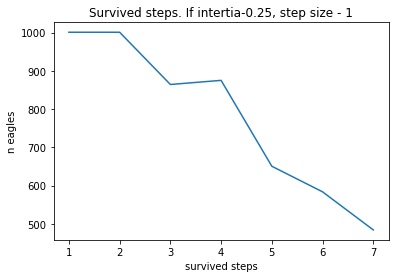

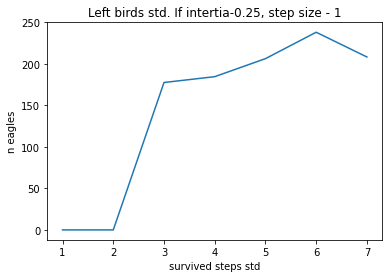

In [35]:
inertia = 0.25
step_size = 1

mask_speed = parsed_result['new_egale_speed_space'] == inertia
mask_step_size = parsed_result['new_eagles_step_size_space'] == step_size

plt.title(f'Survived steps. If intertia-{inertia}, step size - {step_size}')
plt.plot(
    parsed_result['new_n_eagles_space'][mask_speed & mask_step_size], 
    left_birds[mask_speed & mask_step_size]
)
plt.xlabel('survived steps')
plt.ylabel('n eagles')
plt.show()

plt.title(f'Survived steps std. If intertia-{inertia}, step size - {step_size}')
plt.plot(
    parsed_result['new_n_eagles_space'][mask_speed & mask_step_size], 
    left_birds_std[mask_speed & mask_step_size]
)
plt.xlabel('survived steps std')
plt.ylabel('n eagles')
plt.show()

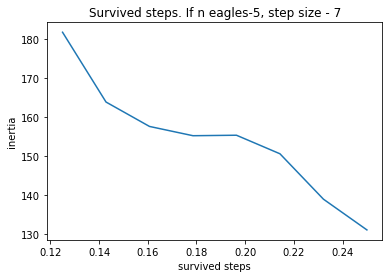

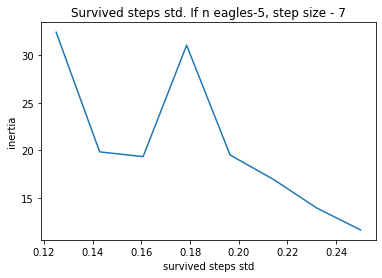

In [41]:
n_eagles = 5
step_size = 7

mask_n = parsed_result['new_n_eagles_space'] == n_eagles
mask_step_size = parsed_result['new_eagles_step_size_space'] == step_size

plt.title(f'Survived steps. If n eagles-{n_eagles}, step size - {step_size}')
plt.plot(
    parsed_result['new_egale_speed_space'][mask_n & mask_step_size], 
    left_birds[mask_n & mask_step_size]
)
plt.xlabel('survived steps')
plt.ylabel('inertia')
plt.show()

plt.title(f'Survived steps std. If n eagles-{n_eagles}, step size - {step_size}')
plt.plot(
    parsed_result['new_egale_speed_space'][mask_n & mask_step_size], 
    left_birds_std[mask_n & mask_step_size]
)
plt.xlabel('survived steps std')
plt.ylabel('inertia')
plt.show()

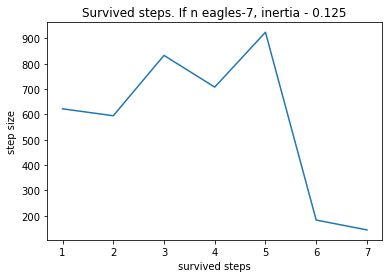

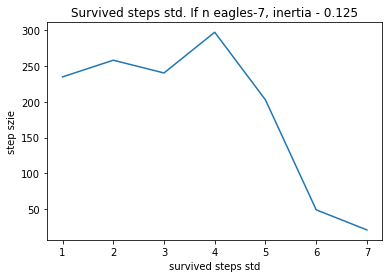

In [45]:
n_eagles = 7
inertia = 0.125

mask_n = parsed_result['new_n_eagles_space'] == n_eagles
mask_speed = parsed_result['new_egale_speed_space'] == inertia

plt.title(f'Survived steps. If n eagles-{n_eagles}, inertia - {inertia}')
plt.plot(
    parsed_result['new_eagles_step_size_space'][mask_n & mask_speed], 
    left_birds[mask_n & mask_speed]
)
plt.xlabel('survived steps')
plt.ylabel('step size')
plt.show()

plt.title(f'Survived steps std. If n eagles-{n_eagles}, inertia - {inertia}')
plt.plot(
    parsed_result['new_eagles_step_size_space'][mask_n & mask_speed], 
    left_birds_std[mask_n & mask_speed]
)
plt.xlabel('survived steps std')
plt.ylabel('step szie')
plt.show()